In [2]:
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
import seaborn as sns
import pandas as pd
import pickle

## Data pre-processing

In [59]:
# Utility functions
def load_data():
    """load data."""
    f = open(f"dataset/x_train.csv")
    features = f.readline()
    feature_names = features.split(',')
    data = np.loadtxt(f"dataset/x_train.csv", delimiter=",", skiprows=1, dtype=str)
    return data,feature_names

def convert_row_to_float(row):
    """Convert values in row to float or np.nan."""
    new_row = []
    for item in row:
        try:
            new_row.append(float(item))
        except ValueError:
            new_row.append(np.nan)
    return np.array(new_row)

def convert_all_rows(data):
    """Convert all rows to float or np.nan."""
    new_data = []
    for row in data:
        new_data.append(convert_row_to_float(row))
    return np.array(new_data)

def column_NAN(array):
    nan=0
    for i in range(len(array)):
        if np.isnan(array[i]):
                nan += 1
    return nan

def train_validation_split(data, ratio, seed):
    """Split data into training and validation set."""
    np.random.seed(seed)
    np.random.shuffle(data)
    split_index = int(len(data) * ratio)
    return data[:split_index], data[split_index:]

def k_fold_split(data, k, seed):
    """Split data into k folds."""
    np.random.seed(seed)
    np.random.shuffle(data)
    return np.array_split(data, k)

def standardize_data(data):
    """Standardize data."""
    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)
    return (data - mean) / std

def number_of_NaNs(list_,data):
    NaNs=np.zeros(len(list_))
    for i in list_:
        NaNs[list_.index(i)]=column_NAN(data[:,list_.index(i)])
    return NaNs

def removing_features(number_NaN,list_,data):
    Removed_features=[]
    for i in range(len(NaNs)):
        if NaNs[i] > round(len(data))*0.1:
            Removed_features.append(i)
    reduced_data = np.delete(data, Removed_features, 1)
    reduced_list = list(filter(lambda x: list_.index(x) not in Removed_features, list_))
    return reduced_data, reduced_list

def clean_outliers(X):
    for column in range(X.shape[1]):  # for each feature:
        # calculating 25th and 75th quantiles
        q1_X = np.nanquantile(X[:, column], 0.25, axis=0)
        q3_X = np.nanquantile(X[:, column], 0.75, axis=0)
        IQR_X = q3_X - q1_X  # inter quantile range
        # calculating lower and upper bounds
        lower_bound = q1_X - 1.5 * IQR_X
        upper_bound = q3_X + 1.5 * IQR_X
        # finding which observations are outside/inside of the bounds
        above = X[:, column] > upper_bound
        below = X[:, column] < lower_bound
        outside = above | below
        inside = np.invert(outside)
        # calculate median value of observations that are inside boundaries
        median = np.median(X[inside, column])
        # setting outliers equal to median
        X[outside, column] = median
    return X

def replace_NaN_mean_column(column):
    mean=np.nanmean(column)
    for i in range(len(column)):
        if np.isnan(column[i]):
            column[i]=mean
    return column


def replace_NaN_mean(matrix): 
    for i in range(matrix.shape[1]):
        matrix[:,i] = replace_NaN_mean_column(matrix[:,i])
    return matrix

#### Loading data

In [4]:
numpy_data, features = load_data()

#### Converting to float

In [5]:
data = convert_all_rows(numpy_data)

#### Removing id column in data

In [13]:
data = np.delete(data,0,1)

In [15]:
features.pop(0)

'Id'

#### Finding number of NaN for each feature

In [60]:
NaNs = number_of_NaNs(features,data)

#### Histogram NaN before removing colums

Text(0.5, 1.0, 'Number of NaNs per feature')

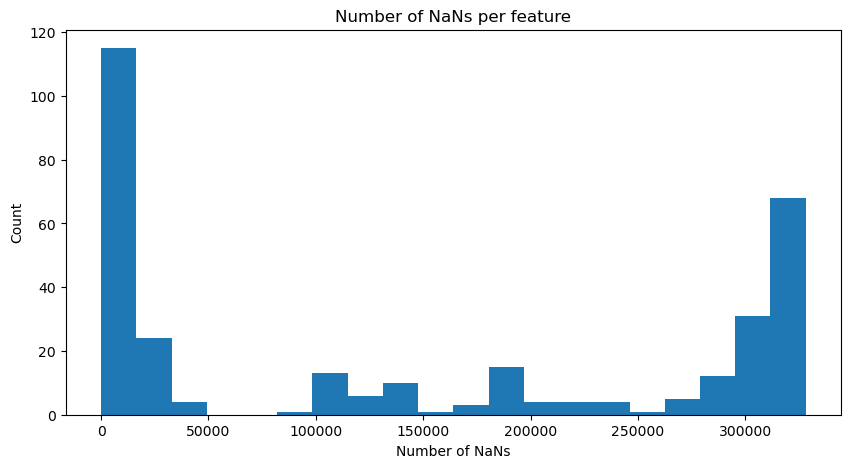

In [61]:
plt.figure(figsize=(10, 5))
plt.hist(NaNs, bins=20)
plt.xlabel("Number of NaNs")
plt.ylabel("Count")
plt.title("Number of NaNs per feature")

#### Removing features with too many NaNs

In [62]:
reduced_data, reduced_features = removing_features(NaNs,features,data)

#### Histogram NaNs after dropping features 

In [64]:
Reduced_NaNs = number_of_NaNs(reduced_features,reduced_data)

Text(0.5, 1.0, 'Number of NaNs per feature')

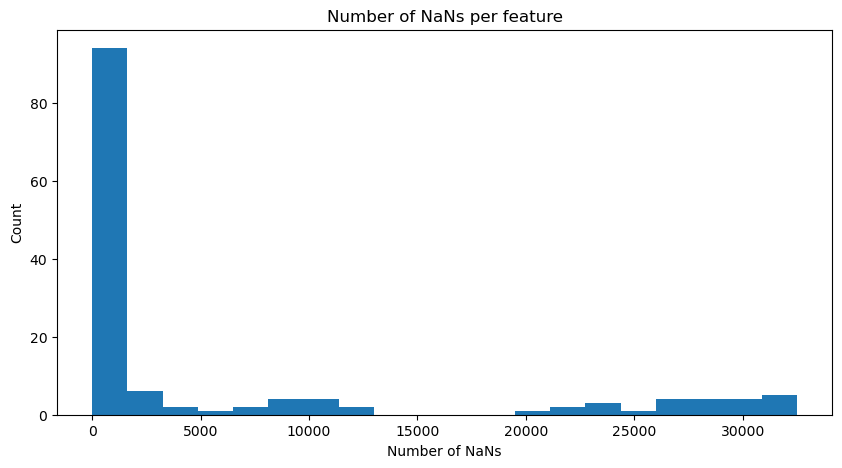

In [65]:
plt.figure(figsize=(10, 5))
plt.hist(Reduced_NaNs, bins=20)
plt.xlabel("Number of NaNs")
plt.ylabel("Count")
plt.title("Number of NaNs per feature")

Still quite a few features with a lot of NaNs (more than 20000) might consider increasing min level to 95 or 99%

#### Dealing with outliers

In [66]:
removed_outlier_data = clean_outliers(reduced_data)

#### Dealing with NaNs

In [67]:
reduced_data_mean = replace_NaN_mean(removed_outlier_data)

In [68]:
NaN_test=number_of_NaNs(reduced_features,reduced_data_mean)

Text(0.5, 1.0, 'Number of NaNs per feature')

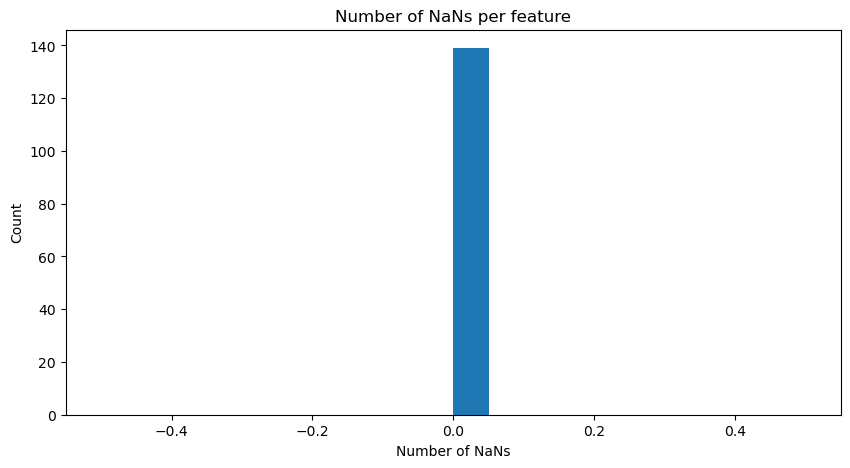

In [69]:
plt.figure(figsize=(10, 5))
plt.hist(NaN_test, bins=20)
plt.xlabel("Number of NaNs")
plt.ylabel("Count")
plt.title("Number of NaNs per feature")

We can also try with mode or other stuffs, but here I computed the mean before the NaNs, not sure if it impacts a lot the results to do it the other way around

Now we need to deal on the categorical features, I don't know how you want to proceed